In [1]:
import torch
print(f"Can work with GPU?: {torch.cuda.is_available()}")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamPredictor

Can work with GPU?: True


In [ ]:
"""
1. Load in the images
2. Load in the annotations
3. Use this as the prompt for the SAM
4. Run SAM with top 3
5. Store all 3 masks
6. Pick best masks and store

Dataset -> SAM segmented -> Data augmented (in process of model) -> Model training

Pipeline:
Image upload -> click on point for SAM segmentation -> predict model -> return probabilities
"""

### Load in Annotations

In [31]:
from bs4 import BeautifulSoup

# file to a variable under the name 
# data
with open('annotations 2.xml', 'r') as f:
    data = f.read()

# the beautifulsoup parser, storing
# the returned object 
soup = BeautifulSoup(data, "xml")

images = soup.select("image")

In [35]:
images[0]

<image height="720" id="0" name="baars1.jpg" width="1280">
<points label="fish" occluded="0" points="628.76,420.06" source="manual" z_order="0">
</points>
</image>

In [49]:
species = "baars"
image_n = images[0]

def get_image_data(species, image):
    file_path = f"dataset/dataset_new/{species}/{image['name']}"
    x,y = image.select("points")[0]['points'].split(",")
    x,y = int(float(x)), int(float(y))
    return file_path, x,y

### Helper Functions

In [2]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

In [3]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())

1.13.1+cu117
11.7
8500


In [4]:
device = 'cuda'

### Setup SAM

In [8]:
sam = sam_model_registry["default"](checkpoint="./sam_vit_h_4b8939.pth")

In [9]:
sam.to(device='cuda');

In [10]:
predictor = SamPredictor(sam)

### Process Image

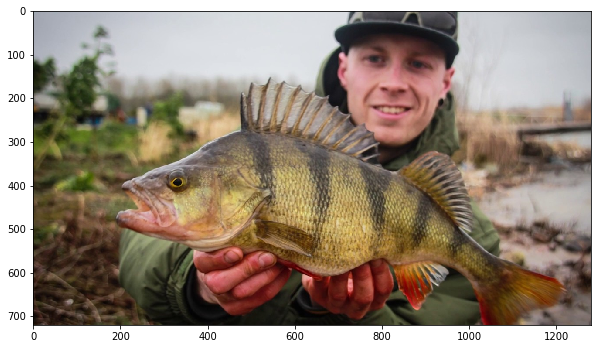

In [50]:
file_name, x, y = get_image_data(species, image_n)


image = cv2.imread(file_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [51]:
predictor.set_image(image)

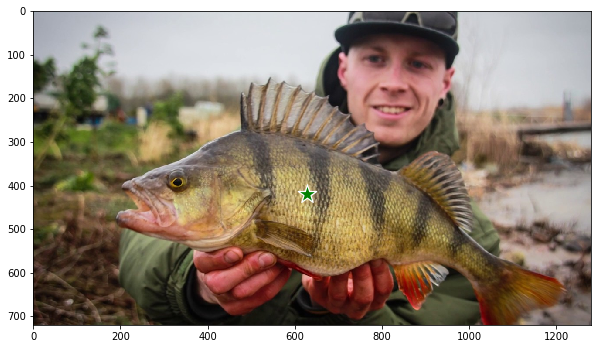

In [52]:
input_point = np.array([[x,y]])
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [53]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

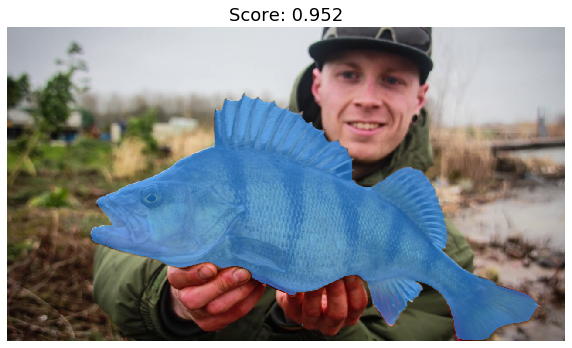

In [57]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[1], plt.gca())
# show_points(input_point, input_label, plt.gca())
plt.title(f"Score: {scores[0]:.3f}", fontsize=18)
plt.axis('off')
plt.show()

In [64]:
y=np.expand_dims(masks[1],axis=2)
newmask=np.concatenate((y,y,y),axis=2)
cob= image * newmask

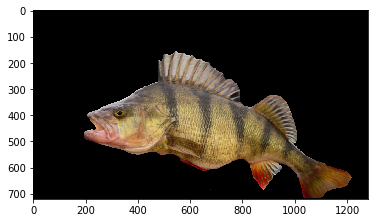

In [65]:
plt.imshow(cob)

### Plot Multiple

In [66]:
# for i, (mask, score) in enumerate(zip(masks, scores)):
#     plt.figure(figsize=(10,10))
#     plt.imshow(image)
#     show_mask(mask, plt.gca())
#     show_points(input_point, input_label, plt.gca())
#     plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
#     plt.axis('off')
#     plt.show()  